# Task 1 - Data Preprocessing

### Importing Libraries

In [1]:
# Import necessary libraries
import warnings
import pyspark
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import pyspark.sql as pyspark_sql
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import isnan, when, count, mean, stddev, col, median
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_date

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/21 21:32:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Reading Datasets


In [4]:
# reading datasets using pyspark
df1 = spark.read.csv("datasets/col_mat_nuw_output.csv", header=False)
df2 = spark.read.csv("datasets/kan_output.csv", header=False)
df3 = spark.read.csv("datasets/mon_kur_jaf_output.csv", header=False)

### Check for missing values in each dataframe


In [5]:
df1.show()

+--------------------+--------------+----------+----------+
|                 _c0|           _c1|       _c2|       _c3|
+--------------------+--------------+----------+----------+
|0.000196983439578...|Colombo Proper|2019-01-01|2019-01-02|
|0.000262552217196...|Colombo Proper|2019-01-02|2019-01-03|
|9.852118897938794...|Colombo Proper|2019-01-03|2019-01-04|
|0.000209932051811...|Colombo Proper|2019-01-04|2019-01-05|
|0.000178533729889...|Colombo Proper|2019-01-05|2019-01-06|
|0.000108229670023...|Colombo Proper|2019-01-06|2019-01-07|
|0.000392682928047...|Colombo Proper|2019-01-07|2019-01-08|
|9.153156350685351...|Colombo Proper|2019-01-08|2019-01-09|
|0.000120597899285...|Colombo Proper|2019-01-09|2019-01-10|
|0.000129772356298...|Colombo Proper|2019-01-10|2019-01-11|
|0.000223918816680...|Colombo Proper|2019-01-11|2019-01-12|
|0.000156941809417...|Colombo Proper|2019-01-12|2019-01-13|
|                NULL|Colombo Proper|2019-01-13|2019-01-14|
|0.000133629190686...|Colombo Proper|201

In [6]:
# define a function to check missing values
def missingValues(df):
    missing_values = {col:df.filter(df[col].isNull()).count() for col in df.columns}
    
    return missing_values

In [7]:
missingValues(df1)

{'_c0': 2419, '_c1': 0, '_c2': 0, '_c3': 0}

In [8]:
df2.show()

+--------------------+------------+----------+----------+
|                 _c0|         _c1|       _c2|       _c3|
+--------------------+------------+----------+----------+
|0.000176071345987...|Kandy Proper|2019-01-01|2019-01-02|
|9.220391253917748...|Kandy Proper|2019-01-02|2019-01-03|
|                NULL|Kandy Proper|2019-01-03|2019-01-04|
|0.000190868198385...|Kandy Proper|2019-01-04|2019-01-05|
|0.000121951784020...|Kandy Proper|2019-01-05|2019-01-06|
|-6.51408612938880...|Kandy Proper|2019-01-06|2019-01-07|
| 0.00016323820639265|Kandy Proper|2019-01-07|2019-01-08|
|-6.73520553391426...|Kandy Proper|2019-01-08|2019-01-09|
|0.000127969365824...|Kandy Proper|2019-01-09|2019-01-10|
|4.546048424126012...|Kandy Proper|2019-01-10|2019-01-11|
|3.600074175192105...|Kandy Proper|2019-01-11|2019-01-12|
|0.000128662969801...|Kandy Proper|2019-01-12|2019-01-13|
|                NULL|Kandy Proper|2019-01-13|2019-01-14|
|                NULL|Kandy Proper|2019-01-14|2019-01-15|
|9.63639634671

In [9]:
missingValues(df2)

{'_c0': 793, '_c1': 0, '_c2': 0, '_c3': 0}

In [10]:
df3.show()

+--------------------+------------------+----------+----------+
|                 _c0|               _c1|       _c2|       _c3|
+--------------------+------------------+----------+----------+
|                NULL|Bibile, Monaragala|2019-01-01|2019-01-02|
|1.919914652467399...|Bibile, Monaragala|2019-01-02|2019-01-03|
|2.811447935930283...|Bibile, Monaragala|2019-01-03|2019-01-04|
|3.747998184385943...|Bibile, Monaragala|2019-01-04|2019-01-05|
|-1.79826087934531...|Bibile, Monaragala|2019-01-05|2019-01-06|
|0.000145783689617...|Bibile, Monaragala|2019-01-06|2019-01-07|
|2.828590802546534...|Bibile, Monaragala|2019-01-07|2019-01-08|
|                NULL|Bibile, Monaragala|2019-01-08|2019-01-09|
|0.000142085016705...|Bibile, Monaragala|2019-01-09|2019-01-10|
|                NULL|Bibile, Monaragala|2019-01-10|2019-01-11|
|2.014587947072581...|Bibile, Monaragala|2019-01-11|2019-01-12|
|0.000158278766321...|Bibile, Monaragala|2019-01-12|2019-01-13|
|                NULL|Bibile, Monaragala

In [11]:
missingValues(df3)

{'_c0': 1652, '_c1': 0, '_c2': 0, '_c3': 0}

In [12]:
# add column headings to the dataframe
column_names = ["HCHO reading", "Location", "Current Date", "Next Date"]
hcho_df1 = df1.toDF(*column_names)
hcho_df2 = df2.toDF(*column_names)
hcho_df3 = df3.toDF(*column_names)

In [13]:
hcho_df1.show()

+--------------------+--------------+------------+----------+
|        HCHO reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|0.000196983439578...|Colombo Proper|  2019-01-01|2019-01-02|
|0.000262552217196...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794...|Colombo Proper|  2019-01-03|2019-01-04|
|0.000209932051811...|Colombo Proper|  2019-01-04|2019-01-05|
|0.000178533729889...|Colombo Proper|  2019-01-05|2019-01-06|
|0.000108229670023...|Colombo Proper|  2019-01-06|2019-01-07|
|0.000392682928047...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351...|Colombo Proper|  2019-01-08|2019-01-09|
|0.000120597899285...|Colombo Proper|  2019-01-09|2019-01-10|
|0.000129772356298...|Colombo Proper|  2019-01-10|2019-01-11|
|0.000223918816680...|Colombo Proper|  2019-01-11|2019-01-12|
|0.000156941809417...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|0.00013

In [14]:
hcho_df2.show()

+--------------------+------------+------------+----------+
|        HCHO reading|    Location|Current Date| Next Date|
+--------------------+------------+------------+----------+
|0.000176071345987...|Kandy Proper|  2019-01-01|2019-01-02|
|9.220391253917748...|Kandy Proper|  2019-01-02|2019-01-03|
|                NULL|Kandy Proper|  2019-01-03|2019-01-04|
|0.000190868198385...|Kandy Proper|  2019-01-04|2019-01-05|
|0.000121951784020...|Kandy Proper|  2019-01-05|2019-01-06|
|-6.51408612938880...|Kandy Proper|  2019-01-06|2019-01-07|
| 0.00016323820639265|Kandy Proper|  2019-01-07|2019-01-08|
|-6.73520553391426...|Kandy Proper|  2019-01-08|2019-01-09|
|0.000127969365824...|Kandy Proper|  2019-01-09|2019-01-10|
|4.546048424126012...|Kandy Proper|  2019-01-10|2019-01-11|
|3.600074175192105...|Kandy Proper|  2019-01-11|2019-01-12|
|0.000128662969801...|Kandy Proper|  2019-01-12|2019-01-13|
|                NULL|Kandy Proper|  2019-01-13|2019-01-14|
|                NULL|Kandy Proper|  201

In [15]:
hcho_df3.show()

+--------------------+------------------+------------+----------+
|        HCHO reading|          Location|Current Date| Next Date|
+--------------------+------------------+------------+----------+
|                NULL|Bibile, Monaragala|  2019-01-01|2019-01-02|
|1.919914652467399...|Bibile, Monaragala|  2019-01-02|2019-01-03|
|2.811447935930283...|Bibile, Monaragala|  2019-01-03|2019-01-04|
|3.747998184385943...|Bibile, Monaragala|  2019-01-04|2019-01-05|
|-1.79826087934531...|Bibile, Monaragala|  2019-01-05|2019-01-06|
|0.000145783689617...|Bibile, Monaragala|  2019-01-06|2019-01-07|
|2.828590802546534...|Bibile, Monaragala|  2019-01-07|2019-01-08|
|                NULL|Bibile, Monaragala|  2019-01-08|2019-01-09|
|0.000142085016705...|Bibile, Monaragala|  2019-01-09|2019-01-10|
|                NULL|Bibile, Monaragala|  2019-01-10|2019-01-11|
|2.014587947072581...|Bibile, Monaragala|  2019-01-11|2019-01-12|
|0.000158278766321...|Bibile, Monaragala|  2019-01-12|2019-01-13|
|         

### Combine the datasets into one dataframe

In [16]:
# combine datasets into one dataframe
df = hcho_df1.union(hcho_df2).union(hcho_df3)
df.show()

row = df.count() # rows count in dataframe
column = len(df.columns) # length of columns in dataframe

print(f'Dimension of the Dataframe: {(row,column)}')

+--------------------+--------------+------------+----------+
|        HCHO reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|0.000196983439578...|Colombo Proper|  2019-01-01|2019-01-02|
|0.000262552217196...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794...|Colombo Proper|  2019-01-03|2019-01-04|
|0.000209932051811...|Colombo Proper|  2019-01-04|2019-01-05|
|0.000178533729889...|Colombo Proper|  2019-01-05|2019-01-06|
|0.000108229670023...|Colombo Proper|  2019-01-06|2019-01-07|
|0.000392682928047...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351...|Colombo Proper|  2019-01-08|2019-01-09|
|0.000120597899285...|Colombo Proper|  2019-01-09|2019-01-10|
|0.000129772356298...|Colombo Proper|  2019-01-10|2019-01-11|
|0.000223918816680...|Colombo Proper|  2019-01-11|2019-01-12|
|0.000156941809417...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|0.00013

In [17]:
# data types in dataframe
df.printSchema()

root
 |-- HCHO reading: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: string (nullable = true)
 |-- Next Date: string (nullable = true)



### Cast appropiate data types to columns

In [18]:
# cast columns to appropriate data types
df = df.withColumn("Current Date", col("Current Date").cast("date"))
df = df.withColumn("Next Date", col("Next Date").cast("date"))
df = df.withColumn("HCHO reading", col("HCHO reading").cast("double"))
df.printSchema()
df.show()

root
 |-- HCHO reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)

+--------------------+--------------+------------+----------+
|        HCHO reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|C

In [19]:
# check for missing values in the dataframe
missingValues(df)

{'HCHO reading': 4864, 'Location': 0, 'Current Date': 0, 'Next Date': 0}

### Convert dataset to pandas and fill missing values

In [20]:
# convert into pandas dataframe
pandas_df = df.toPandas()

# forward fill null values
pandas_df['HCHO reading'] = pandas_df['HCHO reading'].interpolate(method='linear', limit_direction='forward')

# convert back to pyspark dataframe
hcho_df = spark.createDataFrame(pandas_df)
hcho_df.show(100)

# check for missing values
missingValues(hcho_df)

+--------------------+--------------+------------+----------+
|        HCHO reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|1.452855000520681...|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

{'HCHO reading': 0, 'Location': 0, 'Current Date': 0, 'Next Date': 0}

### Drop unnecessary columns

In [21]:
# drop the 'Next Date' column
hcho_df = hcho_df.drop('Next Date') 
hcho_df.show()

+--------------------+--------------+------------+
|        HCHO reading|      Location|Current Date|
+--------------------+--------------+------------+
|1.969834395781014...|Colombo Proper|  2019-01-01|
|2.625522171968594...|Colombo Proper|  2019-01-02|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|
|1.785337298892930...|Colombo Proper|  2019-01-05|
|1.082296700235670...|Colombo Proper|  2019-01-06|
|3.926829280477309...|Colombo Proper|  2019-01-07|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|
|1.205978992853015...|Colombo Proper|  2019-01-09|
|1.297723562983258...|Colombo Proper|  2019-01-10|
|2.239188166801278...|Colombo Proper|  2019-01-11|
|1.569418094178759...|Colombo Proper|  2019-01-12|
|1.452855000520681...|Colombo Proper|  2019-01-13|
|1.336291906862603...|Colombo Proper|  2019-01-14|
|6.374417842690063E-5|Colombo Proper|  2019-01-15|
|1.181062250815020...|Colombo Proper|  2019-01-16|
|2.472555222423037...|Colombo P

In [22]:
# location distribution in dataset
hcho_df.select('Location').distinct().show()

+-------------------+
|           Location|
+-------------------+
|     Colombo Proper|
|   Deniyaya, Matara|
|Nuwara Eliya Proper|
|       Kandy Proper|
| Bibile, Monaragala|
|  Kurunegala Proper|
|      Jaffna Proper|
+-------------------+



### Descriptive statistics based on Loacations

In [23]:
# read HCHO values according to location and get descriptive statistics
descriptive_statistics = hcho_df.groupBy("Location").agg(
    mean("HCHO reading").alias("Mean"),
    median("HCHO reading").alias("Median"),
    stddev("HCHO reading").alias("Standard Deviation")
).orderBy("Location")

descriptive_statistics.show()

+-------------------+--------------------+--------------------+--------------------+
|           Location|                Mean|              Median|  Standard Deviation|
+-------------------+--------------------+--------------------+--------------------+
| Bibile, Monaragala|1.197980555574009...|1.163706608884561...|8.933678348640035E-5|
|     Colombo Proper|1.535346645759827...|1.442955555530137E-4|9.448200849831754E-5|
|   Deniyaya, Matara| 9.25922759000317E-5|8.202891952246218E-5|9.112260479498643E-5|
|      Jaffna Proper|1.073533532100281...|9.930863756796266E-5|7.733540523438506E-5|
|       Kandy Proper|9.912866443378551E-5|9.538579664221356E-5|8.635152937668413E-5|
|  Kurunegala Proper|1.235300181459006E-4|1.144894108806444...|8.275082892026594E-5|
|Nuwara Eliya Proper| 8.22312234995017E-5|7.602816789848191E-5|7.424721285686902E-5|
+-------------------+--------------------+--------------------+--------------------+



## Data Visualization

In [24]:
hcho_pd = hcho_df.toPandas()
hcho_pd

,HCHO reading,Location,Current Date
0,0.000197,Colombo Proper,2019-01-01
1,0.000263,Colombo Proper,2019-01-02
2,0.000099,Colombo Proper,2019-01-03
3,0.000210,Colombo Proper,2019-01-04
4,0.000179,Colombo Proper,2019-01-05
...,...,...,...
12777,0.000026,Jaffna Proper,2023-12-27
12778,0.000051,Jaffna Proper,2023-12-28
12779,0.000127,Jaffna Proper,2023-12-29
12780,0.000117,Jaffna Proper,2023-12-30


In [25]:
# function to create a plot to show HCHO readings
def hcho_readings(location):
    # filter data for the location
    location_data = hcho_pd[hcho_pd['Location'] == location]
    
    # convert 'Current Date' column to datetime
    location_data['Current Date'] = pd.to_datetime(location_data['Current Date'])
    
    # extract year and month from 'Current Date' column
    location_data['Year'] = location_data['Current Date'].dt.year
    location_data['Month'] = location_data['Current Date'].dt.month
    
    # group by year and month and calculate the mean of 'HCHO reading'
    monthly_mean_hcho = location_data.groupby(['Year', 'Month'])['HCHO reading'].mean().reset_index()
    
    # combine year and month columns into a new column
    monthly_mean_hcho['Month_Year'] = monthly_mean_hcho['Month'].astype(str).str.zfill(2) + '/' + monthly_mean_hcho['Year'].astype(str)
    monthly_mean_hcho.sort_values(by=['Year', 'Month'], inplace=True)
    
    # Plotting
    plt.figure(figsize=(20, 6))
    
    # Plotting mean HCHO readings
    plt.plot(monthly_mean_hcho['Month_Year'], monthly_mean_hcho['HCHO reading'], marker='o', linestyle='--')
    plt.title(f"Mean HCHO Readings by Month for {location}")
    plt.xlabel("Month/Year")
    plt.ylabel("Mean HCHO Reading")
    plt.xticks(rotation=90, ha='right')
    plt.grid(True)
    plt.show()

### HCHO readings in Bibile, Monaragala

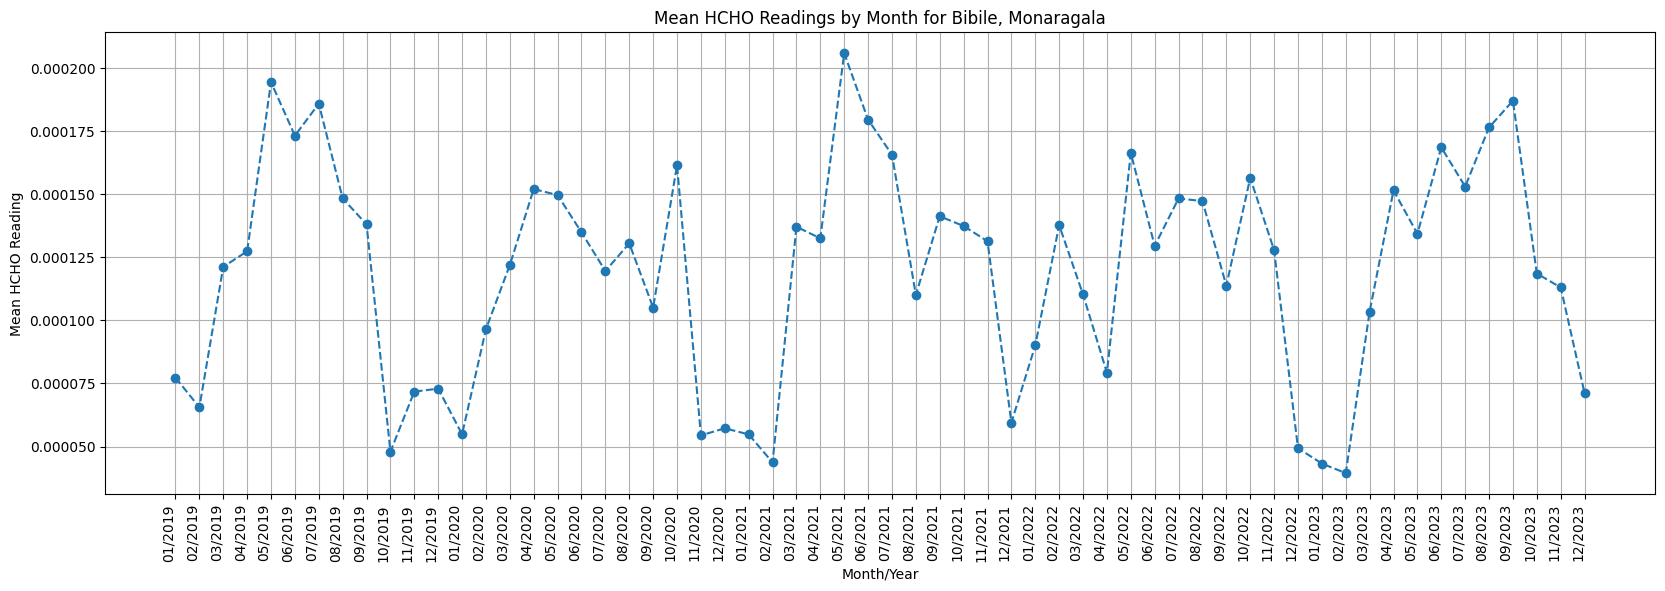

In [26]:
hcho_readings('Bibile, Monaragala')

### HCHO readings in Colombo Proper

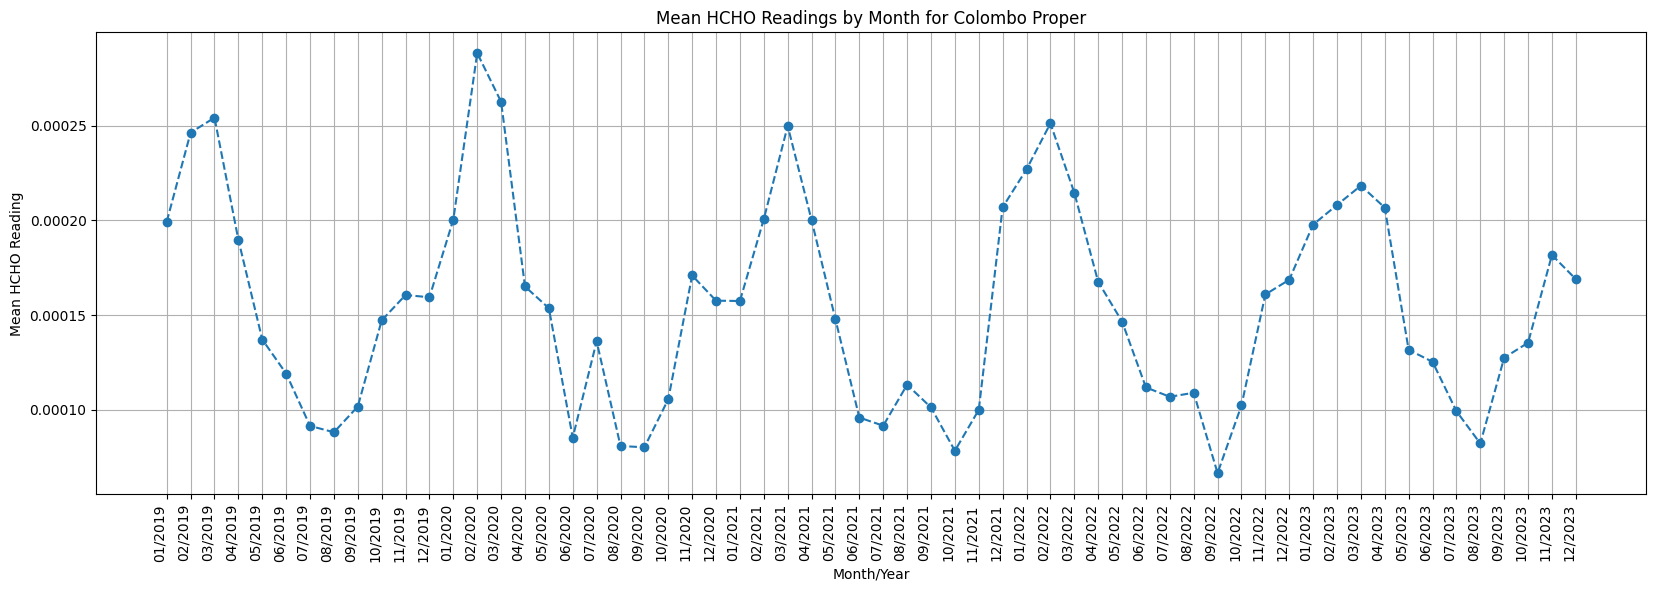

In [27]:
hcho_readings('Colombo Proper')

### HCHO readings in Deniyaya, Matara

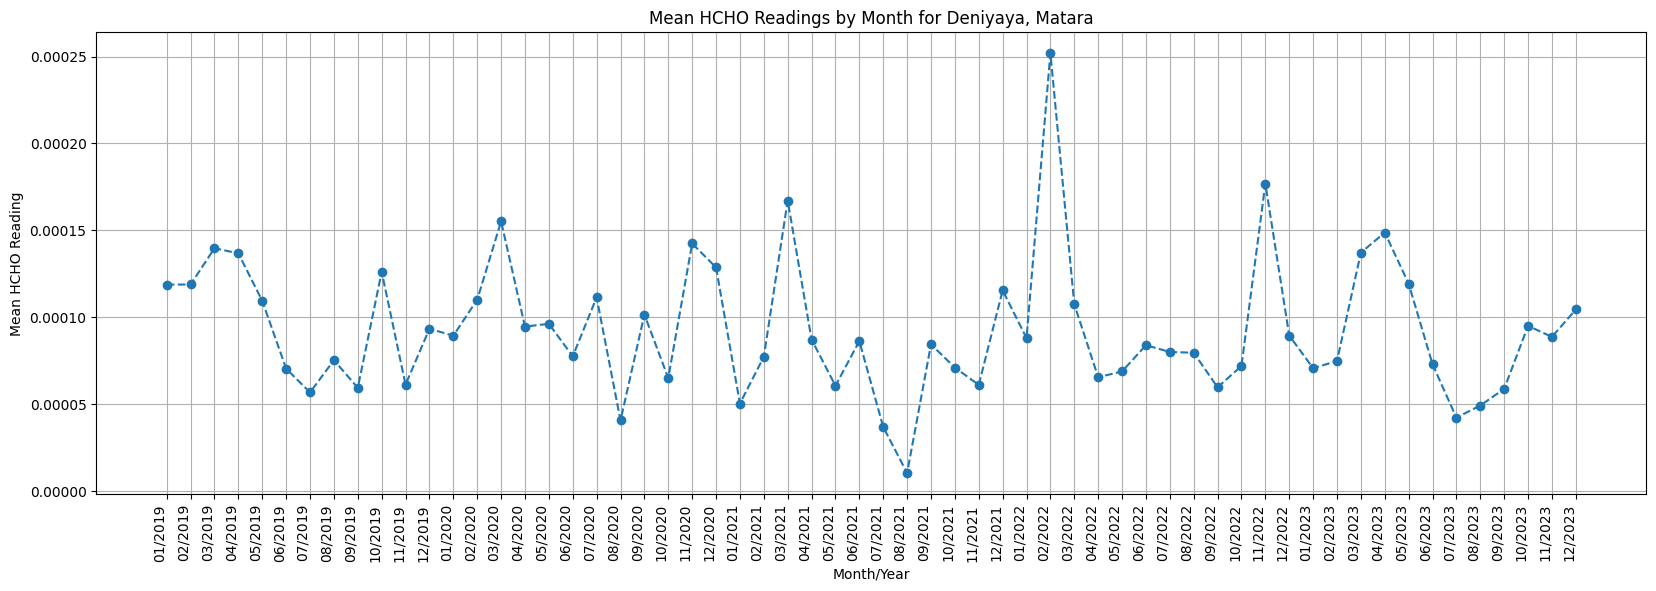

In [28]:
hcho_readings('Deniyaya, Matara')

### HCHO readings in Jaffna Proper

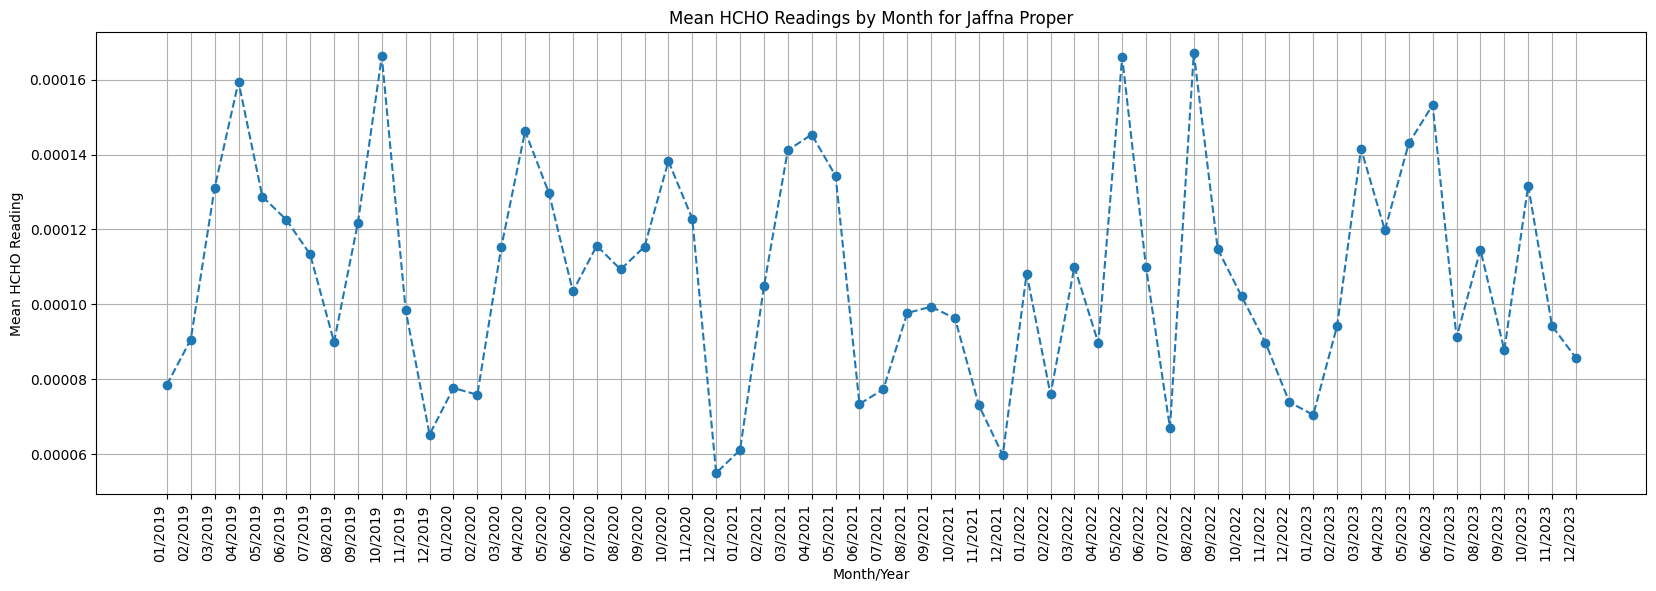

In [29]:
hcho_readings('Jaffna Proper')

### HCHO readings in Kandy Proper

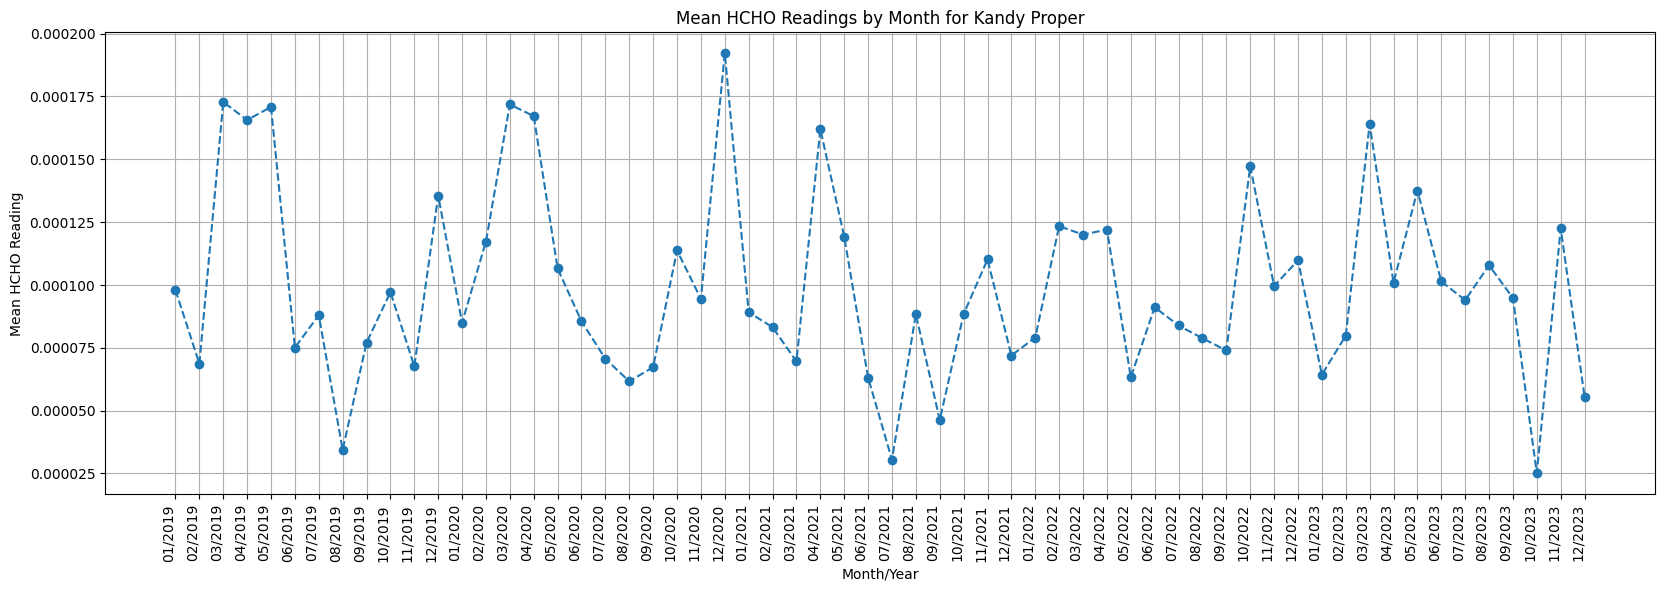

In [30]:
hcho_readings('Kandy Proper')

### HCHO readings in Kurunegala Proper

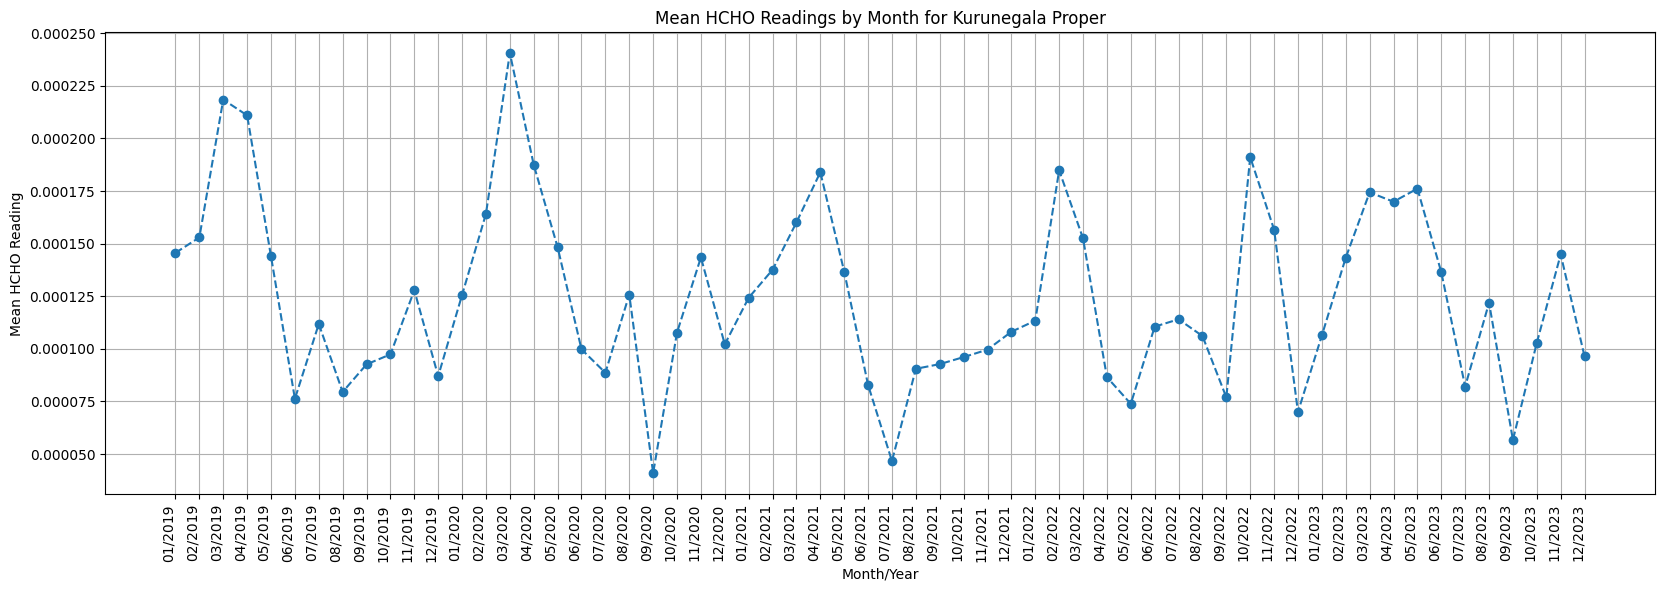

In [31]:
hcho_readings('Kurunegala Proper')

### HCHO readings in Nuwara Eliya Proper

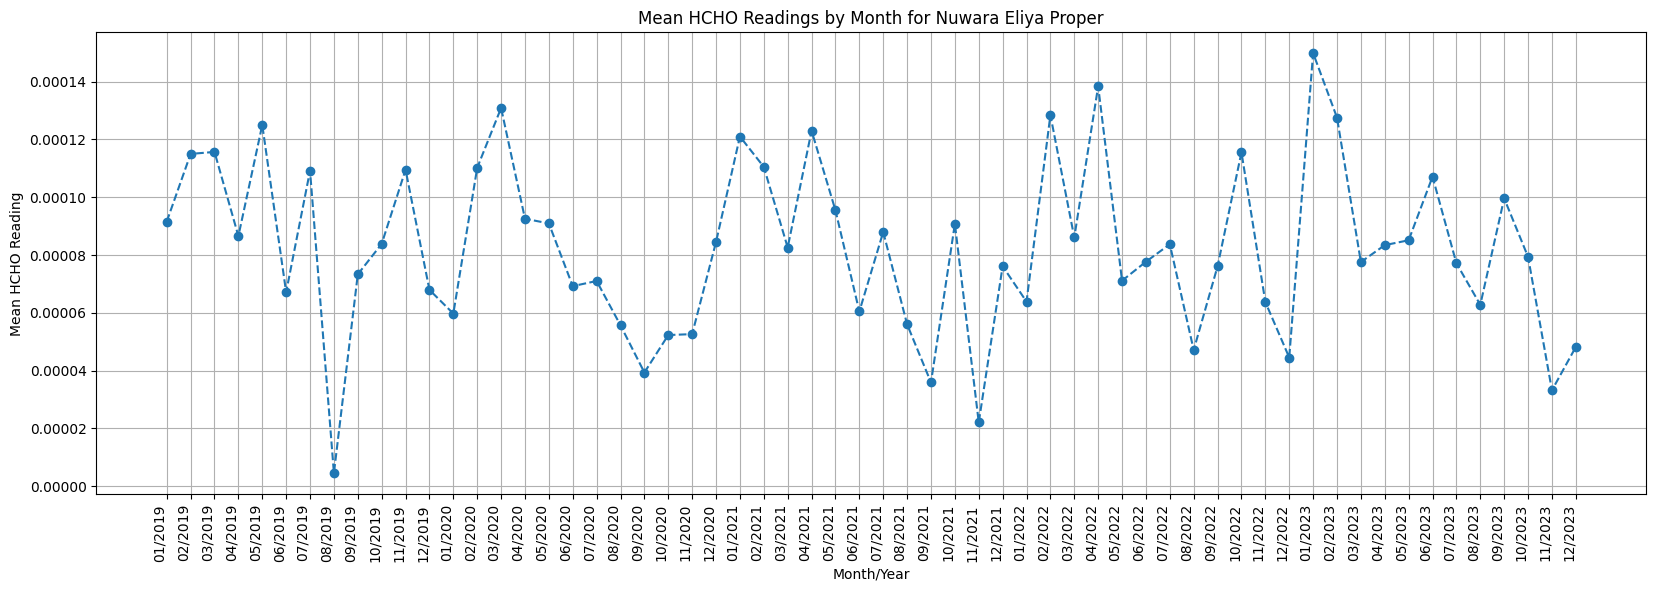

In [32]:
hcho_readings('Nuwara Eliya Proper')

## Manage Outliers

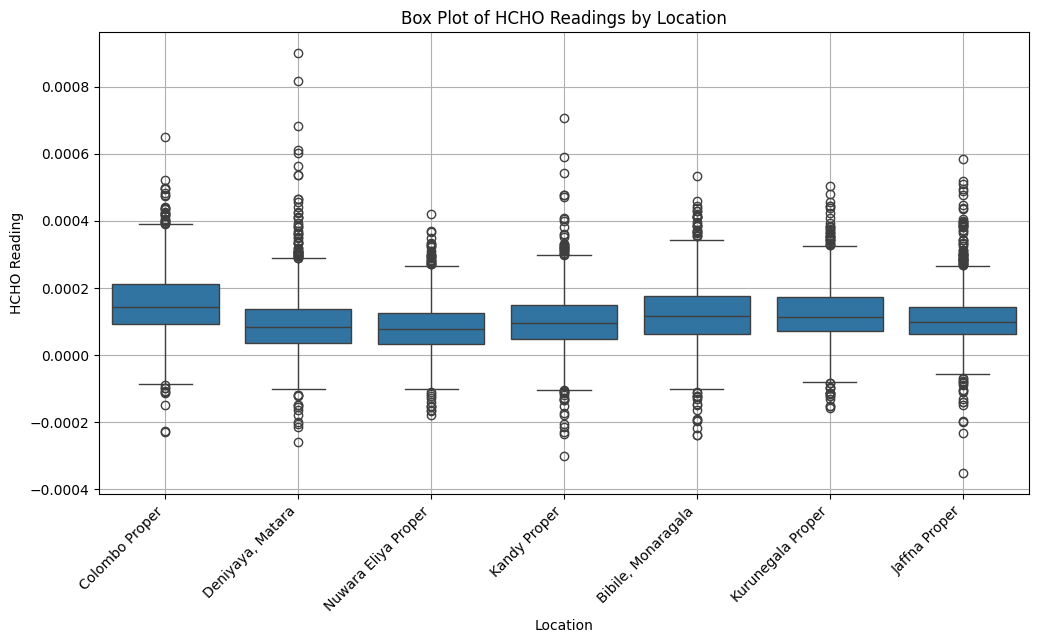

In [33]:
plt.figure(figsize=(12, 6))
    
# Create box plot
sns.boxplot(x='Location', y='HCHO reading', data=hcho_pd)

plt.title("Box Plot of HCHO Readings by Location")
plt.xlabel("Location")
plt.ylabel("HCHO Reading")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

### Filter outliers using IQR method

In [34]:
# treat outliers
quantiles = hcho_df.approxQuantile("HCHO reading", [0.25, 0.75], 0.05)

Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

# define upper and lower bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

hcho_df = hcho_df.filter((col("HCHO reading") >= lower_bound) & (col("HCHO reading") <= upper_bound))

# convert to pandas dataframe
df_pd = hcho_df.toPandas()

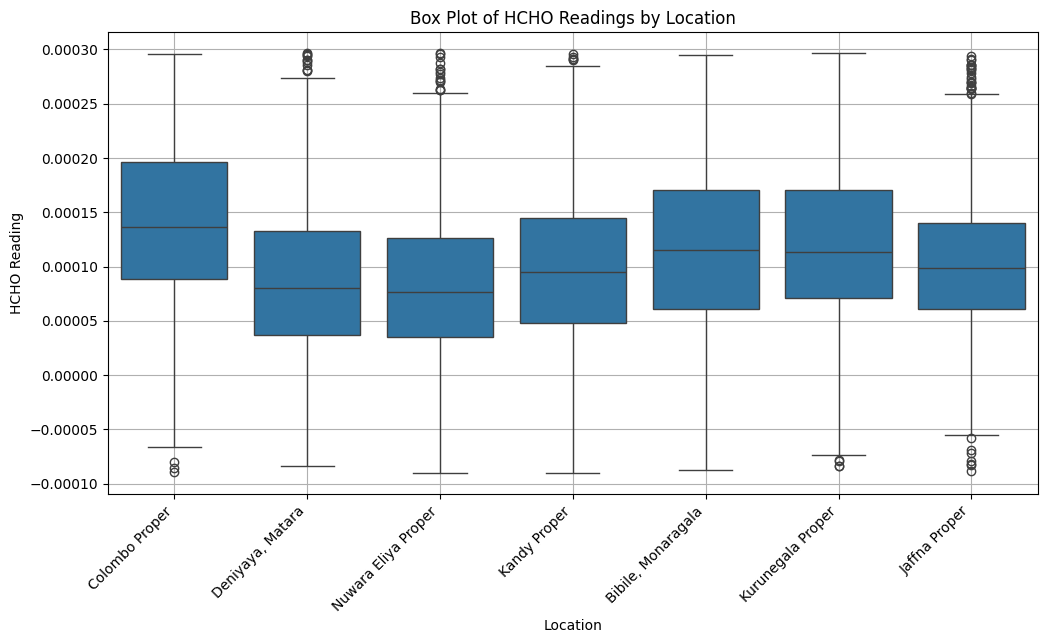

In [35]:
plt.figure(figsize=(12, 6))
    
# Create box plot
sns.boxplot(x='Location', y='HCHO reading', data=df_pd)

plt.title("Box Plot of HCHO Readings by Location")
plt.xlabel("Location")
plt.ylabel("HCHO Reading")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# Task 2 - Spatio-Temporal Analysis

### Identify changes in COVID-19 lockdown

In [36]:
# function to create a plot to show HCHO readings
def covid_readings(location):
    # Filter data for the specified location
    location_data = hcho_pd[hcho_pd['Location'] == location]
    
    # Convert 'Current Date' column to datetime if not already
    location_data['Current Date'] = pd.to_datetime(location_data['Current Date'])
    
    # Extract year and month from 'Current Date'
    location_data['Year'] = location_data['Current Date'].dt.year
    location_data['Month'] = location_data['Current Date'].dt.month
    
    # Group by Location, Year, and Month and calculate the mean of 'HCHO reading'
    monthly_mean_hcho = location_data.groupby(['Year', 'Month'])['HCHO reading'].mean().reset_index()
    
    # Combine Year and Month columns into a new column 'Month_Year' for better x-axis labeling
    monthly_mean_hcho['Month_Year'] = monthly_mean_hcho['Month'].astype(str).str.zfill(2) + '/' + monthly_mean_hcho['Year'].astype(str)
    monthly_mean_hcho.sort_values(by=['Year', 'Month'], inplace=True)
    
    # Find indices corresponding to the lockdown start and end dates
    period1_start = monthly_mean_hcho[monthly_mean_hcho['Month_Year'] == '03/2020'].index[0]
    period1_end = monthly_mean_hcho[monthly_mean_hcho['Month_Year'] == '06/2020'].index[-1]
    period2_start = monthly_mean_hcho[monthly_mean_hcho['Month_Year'] == '05/2021'].index[0]
    period2_end = monthly_mean_hcho[monthly_mean_hcho['Month_Year'] == '07/2021'].index[-1]
    period3_start = monthly_mean_hcho[monthly_mean_hcho['Month_Year'] == '08/2021'].index[0]
    period3_end = monthly_mean_hcho[monthly_mean_hcho['Month_Year'] == '11/2021'].index[-1]
    
    # Plotting
    plt.figure(figsize=(20, 6))
    
    # Plotting mean HCHO readings
    plt.plot(monthly_mean_hcho['Month_Year'], monthly_mean_hcho['HCHO reading'], marker='o', linestyle='--')
    
    # Highlight the area between COVID-19 lockdown dates
    plt.axvspan(period1_start, period1_end, color='red', alpha=0.3, label='COVID-19 Lockdown')
    plt.axvspan(period2_start, period2_end, color='red', alpha=0.3)
    plt.axvspan(period3_start, period3_end, color='red', alpha=0.3)

    plt.title(f"COVID-19 Lockdown Impact for {location}")
    plt.xlabel("Month/Year")
    plt.ylabel("Mean HCHO Reading")
    plt.xticks(rotation=90, ha='right')
    plt.legend()
    plt.grid(True)
    plt.show()

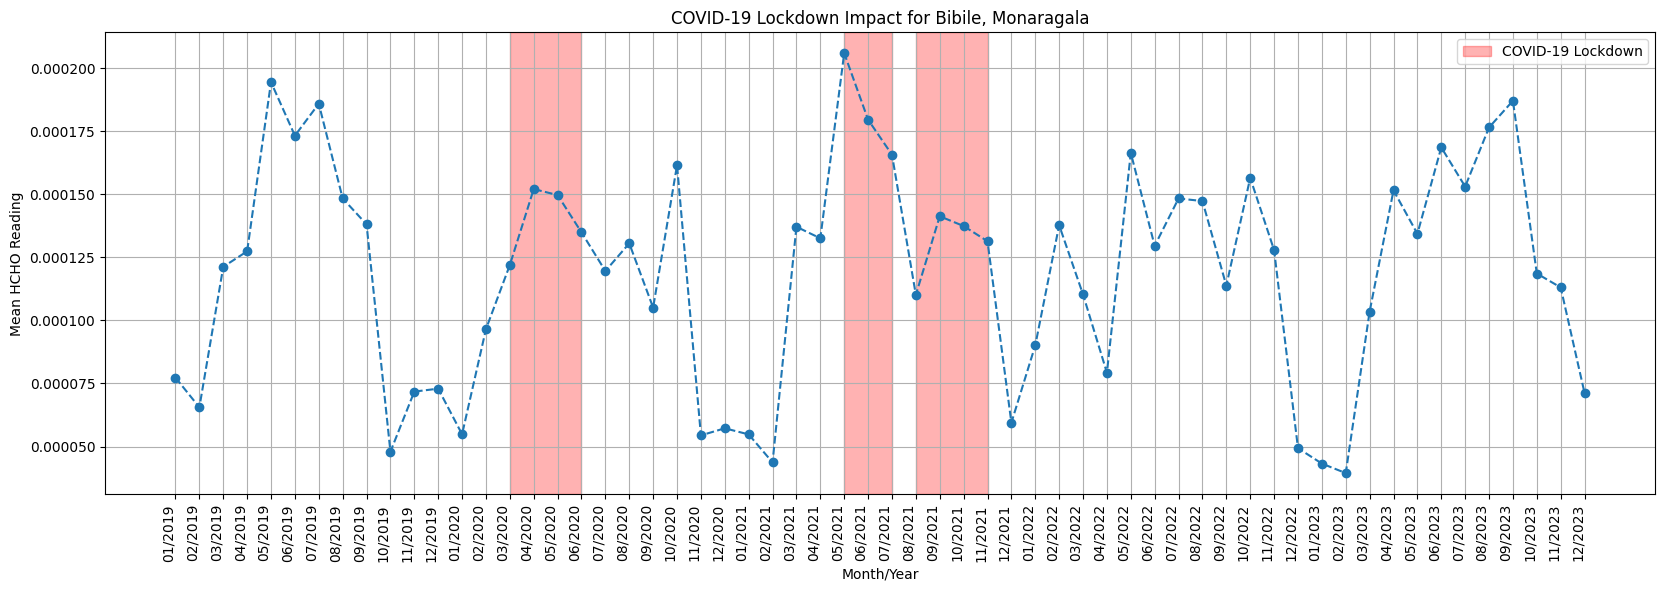

In [37]:
covid_readings('Bibile, Monaragala')

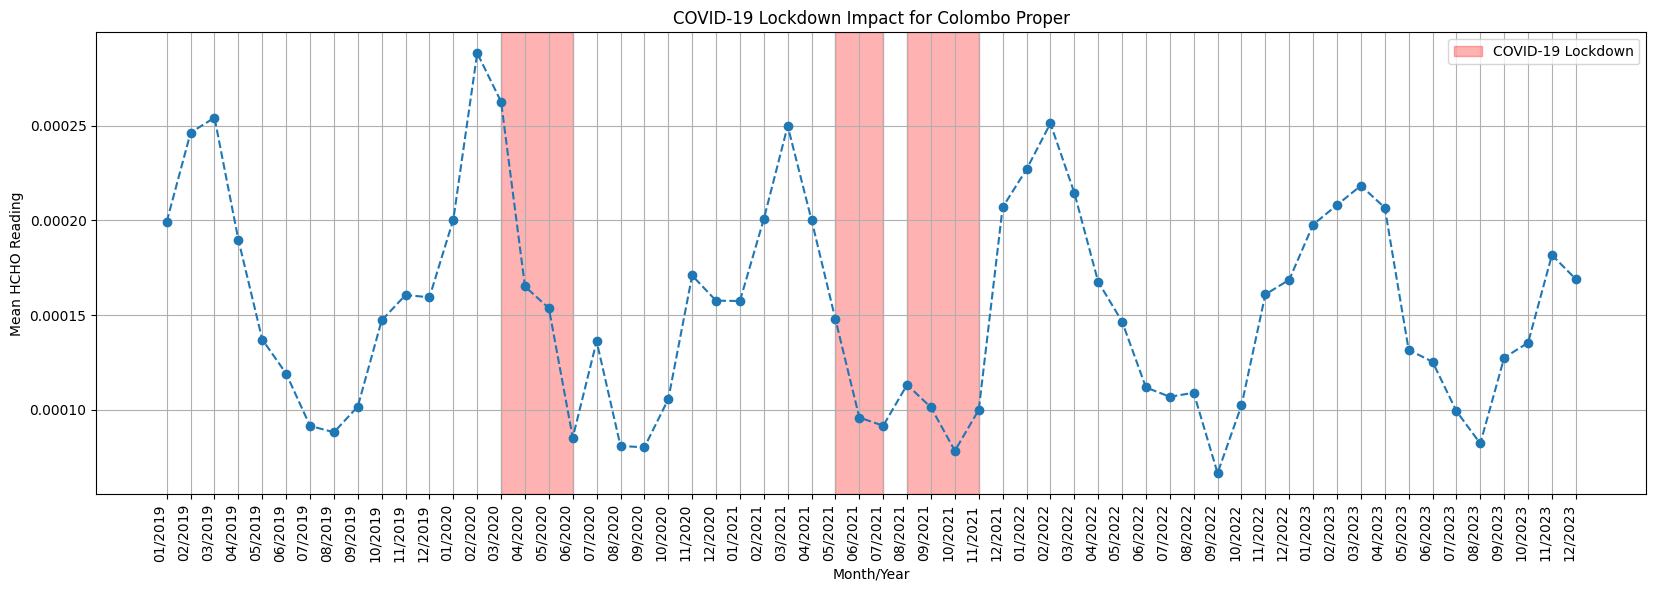

In [38]:
covid_readings('Colombo Proper')

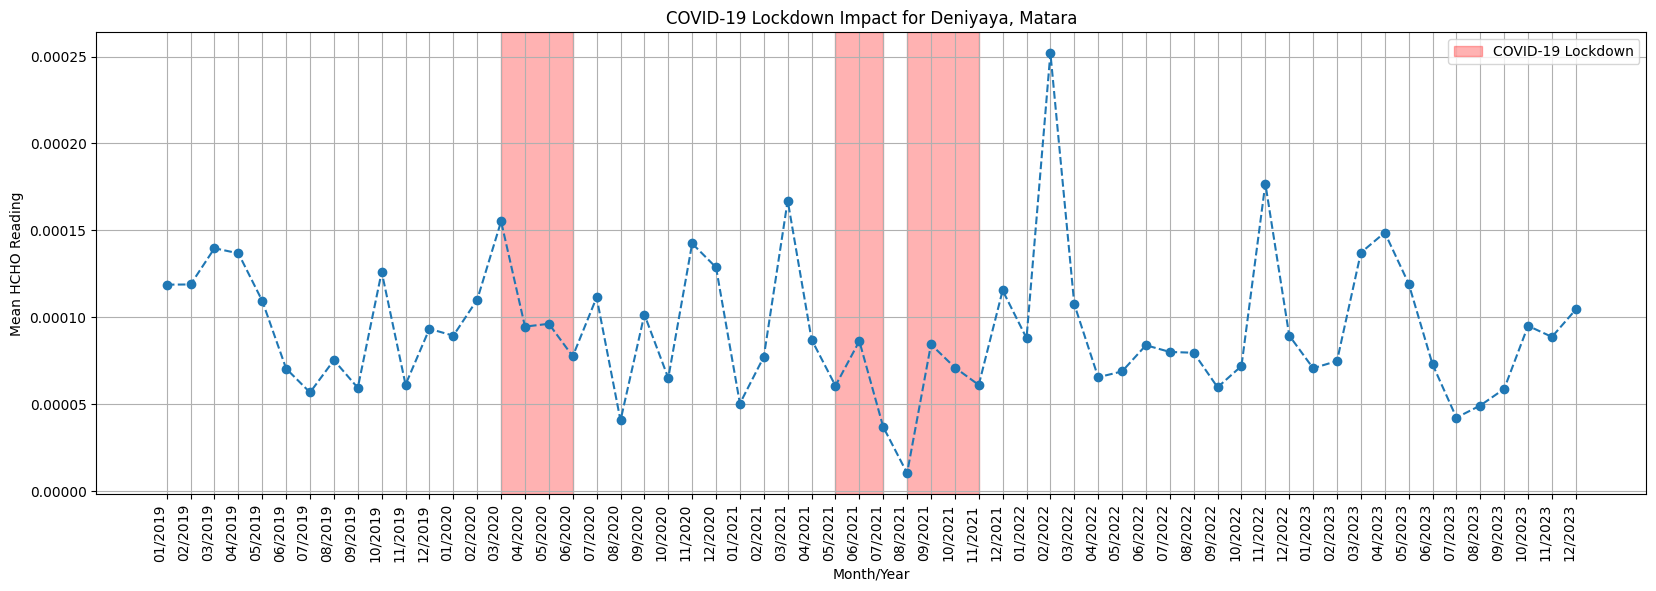

In [39]:
covid_readings('Deniyaya, Matara')

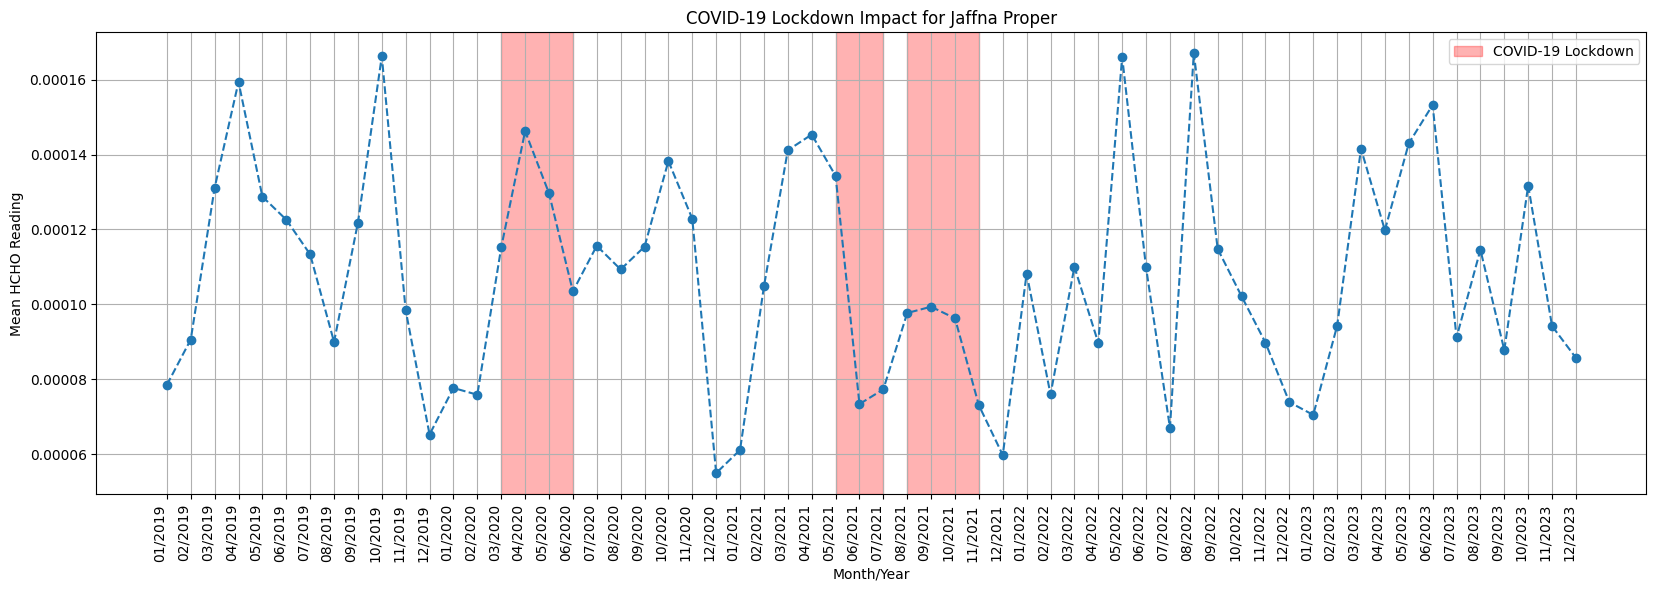

In [40]:
covid_readings('Jaffna Proper')

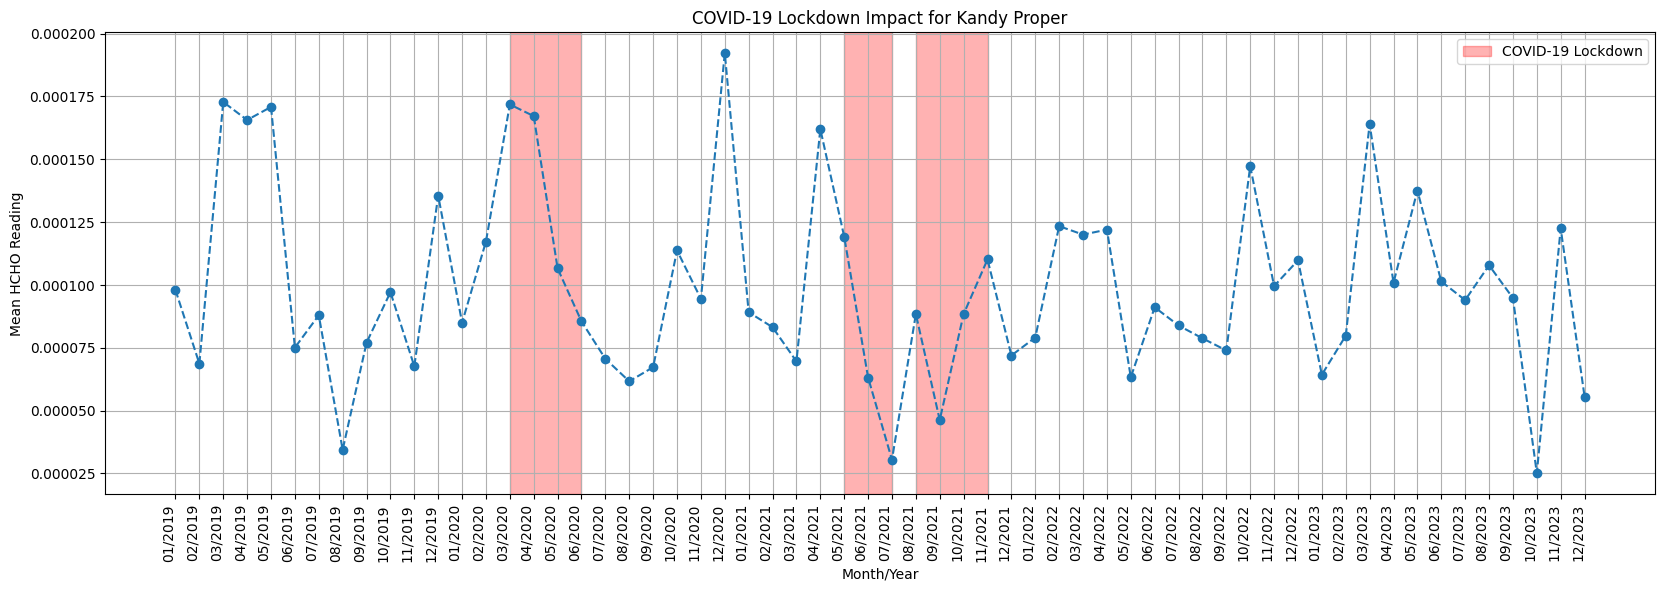

In [41]:
covid_readings('Kandy Proper')

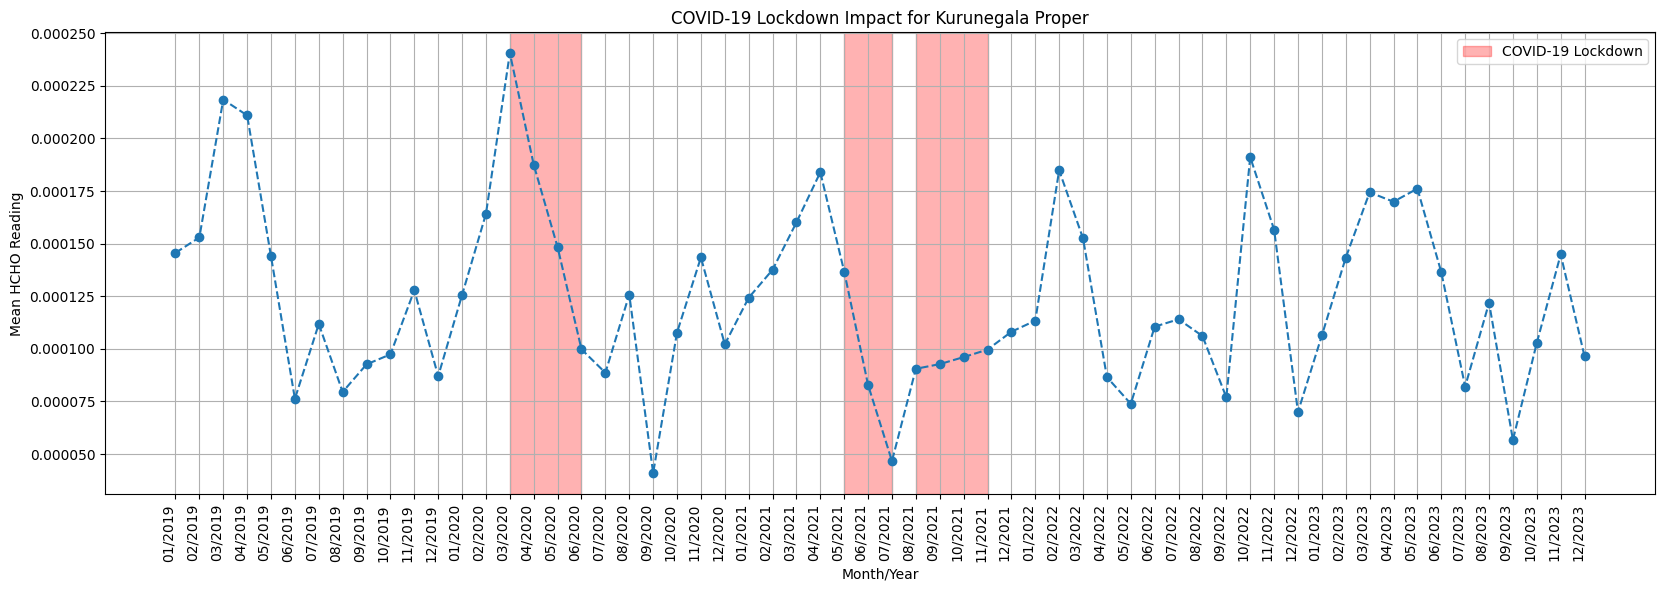

In [42]:
covid_readings('Kurunegala Proper')

### Load the dataset

In [43]:
# load the ncdc dataset
ncdc_pd = pd.read_csv('datasets/ncdc_data.csv')
ncdc_pd

,STATION,NAME,DATE,PRCP,TAVG,TMAX,TMIN
0,CEM00043441,"KURUNEGALA, CE",2019-01-02,0.00,78,83.0,72.0
1,CEM00043441,"KURUNEGALA, CE",2019-01-03,0.00,81,87.0,71.0
2,CEM00043441,"KURUNEGALA, CE",2019-01-04,0.00,83,88.0,69.0
3,CEM00043441,"KURUNEGALA, CE",2019-01-05,0.00,84,90.0,65.0
4,CEM00043441,"KURUNEGALA, CE",2019-01-06,0.00,82,88.0,71.0
...,...,...,...,...,...,...,...
5225,CE000434730,"NUWARA ELIYA, CE",2023-12-27,0.35,61,64.0,59.0
5226,CE000434730,"NUWARA ELIYA, CE",2023-12-28,2.44,61,62.0,60.0
5227,CE000434730,"NUWARA ELIYA, CE",2023-12-29,0.64,60,61.0,59.0
5228,CE000434730,"NUWARA ELIYA, CE",2023-12-30,0.21,60,65.0,57.0


In [44]:
# check for missing values
ncdc_pd.isnull().sum()

STATION      0
NAME         0
DATE         0
PRCP        17
TAVG         0
TMAX       582
TMIN       926
dtype: int64

In [45]:
# ffill missing values
ncdc_pd[['PRCP', 'TMAX', 'TMIN']] = ncdc_pd[['PRCP', 'TMAX', 'TMIN']].interpolate(method='linear', limit_direction='forward', axis=0)
ncdc_pd.isnull().sum()

STATION    0
NAME       0
DATE       0
PRCP       0
TAVG       0
TMAX       0
TMIN       0
dtype: int64

In [46]:
# spark dataframe
ncdc_df = spark.createDataFrame(ncdc_pd)
ncdc_df.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- TAVG: long (nullable = true)
 |-- TMAX: double (nullable = true)
 |-- TMIN: double (nullable = true)



In [47]:
# cast columns to appropriate data types
ncdc_df = ncdc_df.withColumn("DATE", col("DATE").cast("date"))
ncdc_df = ncdc_df.withColumn("TAVG", col("TAVG").cast("double"))
ncdc_df.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- DATE: date (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- TAVG: double (nullable = true)
 |-- TMAX: double (nullable = true)
 |-- TMIN: double (nullable = true)



In [48]:
# name of locations in the dataset
ncdc_df.select('NAME').distinct().show()

+----------------+
|            NAME|
+----------------+
|  KURUNEGALA, CE|
|     COLOMBO, CE|
|NUWARA ELIYA, CE|
+----------------+



In [49]:
# rename locations
name_map = {
    "KURUNEGALA, CE": "Kurunegala Proper",
    "COLOMBO, CE": "Colombo Proper",
    "NUWARA ELIYA, CE": "Nuwara Eliya Proper"
}

# add new names to the dataframe
ncdc_df = ncdc_df.withColumn("NAME", when(ncdc_df["NAME"] == "KURUNEGALA, CE", name_map["KURUNEGALA, CE"])
                                    .when(ncdc_df["NAME"] == "COLOMBO, CE", name_map["COLOMBO, CE"])
                                    .when(ncdc_df["NAME"] == "NUWARA ELIYA, CE", name_map["NUWARA ELIYA, CE"])
                                    .otherwise(ncdc_df["NAME"]))

ncdc_df.select('NAME').distinct().show()

+-------------------+
|               NAME|
+-------------------+
|  Kurunegala Proper|
|     Colombo Proper|
|Nuwara Eliya Proper|
+-------------------+



In [50]:
ncdc_df.show()
ncdc = ncdc_df.toPandas()
ncdc.to_csv('ncdc.csv', index=False)

+-----------+-----------------+----------+----+----+----+----+
|    STATION|             NAME|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+-----------------+----------+----+----+----+----+
|CEM00043441|Kurunegala Proper|2019-01-02| 0.0|78.0|83.0|72.0|
|CEM00043441|Kurunegala Proper|2019-01-03| 0.0|81.0|87.0|71.0|
|CEM00043441|Kurunegala Proper|2019-01-04| 0.0|83.0|88.0|69.0|
|CEM00043441|Kurunegala Proper|2019-01-05| 0.0|84.0|90.0|65.0|
|CEM00043441|Kurunegala Proper|2019-01-06| 0.0|82.0|88.0|71.0|
|CEM00043441|Kurunegala Proper|2019-01-07| 0.0|80.0|89.0|68.0|
|CEM00043441|Kurunegala Proper|2019-01-08| 0.0|82.0|90.0|71.0|
|CEM00043441|Kurunegala Proper|2019-01-09| 0.0|83.0|89.0|71.0|
|CEM00043441|Kurunegala Proper|2019-01-10| 0.0|81.0|88.0|72.0|
|CEM00043441|Kurunegala Proper|2019-01-11| 0.0|85.0|90.0|73.0|
|CEM00043441|Kurunegala Proper|2019-01-12| 0.0|84.0|90.0|74.0|
|CEM00043441|Kurunegala Proper|2019-01-13| 0.0|82.0|87.0|72.0|
|CEM00043441|Kurunegala Proper|2019-01-14| 0.0|80.0|86.

In [51]:
# join the two dataframes
combined = hcho_df.join(ncdc_df, (hcho_df['Location'] == ncdc_df['NAME']) & (hcho_df['Current Date'] == ncdc_df['DATE']), how='inner')
combined.show()

+--------------------+-----------------+------------+-----------+-----------------+----------+----+----+-----------------+----+
|        HCHO reading|         Location|Current Date|    STATION|             NAME|      DATE|PRCP|TAVG|             TMAX|TMIN|
+--------------------+-----------------+------------+-----------+-----------------+----------+----+----+-----------------+----+
|2.901479325215971E-4|Kurunegala Proper|  2019-04-08|CEM00043441|Kurunegala Proper|2019-04-08|0.19|86.0|98.33333333333333|76.0|
|1.464940080416972...|Kurunegala Proper|  2019-10-16|CEM00043441|Kurunegala Proper|2019-10-16|1.48|78.0|             86.0|73.0|
|1.485426858890328...|Kurunegala Proper|  2020-01-13|CEM00043441|Kurunegala Proper|2020-01-13| 0.0|82.0|             90.0|72.0|
|1.387031517931960...|Kurunegala Proper|  2020-01-27|CEM00043441|Kurunegala Proper|2020-01-27| 0.0|83.0|             92.0|72.0|
|1.264302945275396...|Kurunegala Proper|  2020-06-14|CEM00043441|Kurunegala Proper|2020-06-14| 0.0|84.0|

24/04/21 21:33:05 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [52]:
# function to create a plot to HCHO readings vs temperature
def hcho_temperature(location):
    # Filter data for the specified location
    location_data = combined.filter(combined['Location'] == location).toPandas()
    
    # Create a scatter plot of HCHO levels against temperature
    plt.figure(figsize=(10, 6))
    plt.scatter(location_data['TAVG'], location_data['HCHO reading'], alpha=0.5)
    plt.title(f'HCHO Levels vs Temperature in {location}')
    plt.xlabel('Average Temperature (°C)')
    plt.ylabel('HCHO Reading')
    plt.grid(True)
    plt.show()

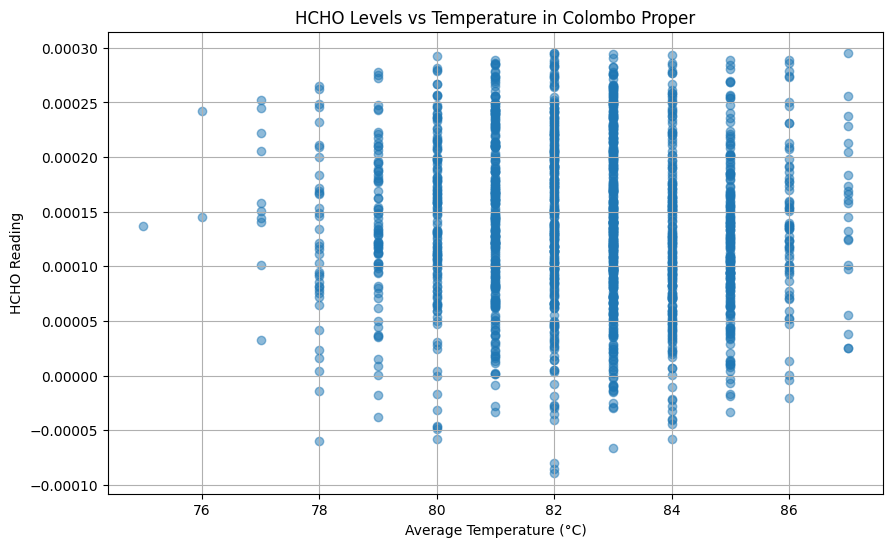

In [53]:
hcho_temperature('Colombo Proper')

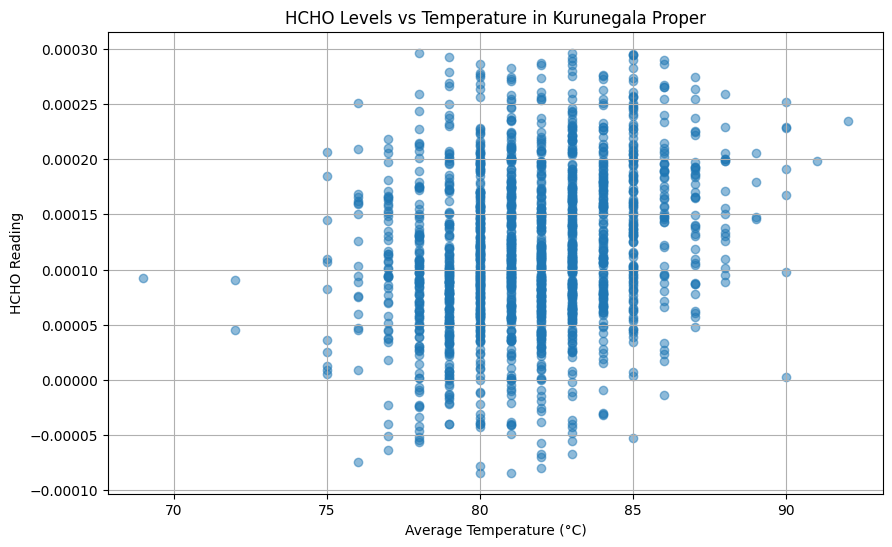

In [54]:
hcho_temperature('Kurunegala Proper')

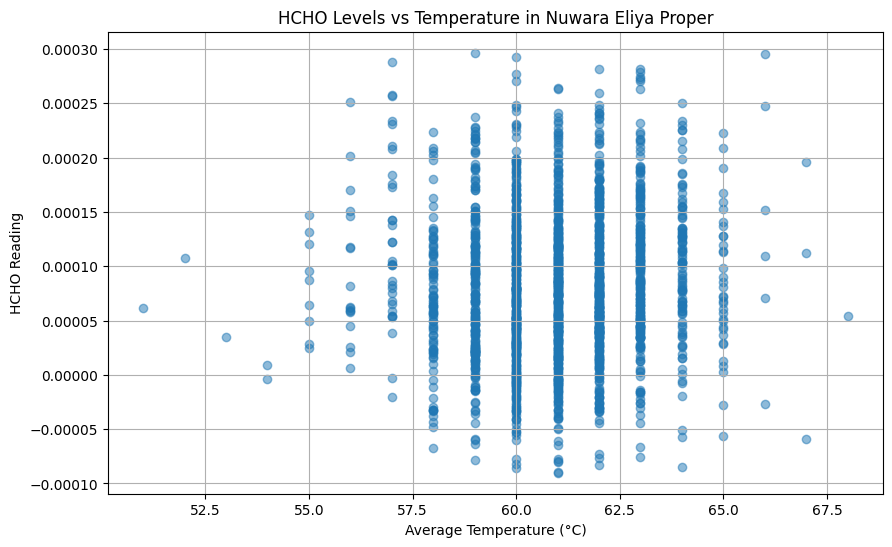

In [55]:
hcho_temperature('Nuwara Eliya Proper')

In [56]:
# filter columns for correlation
columns = ['HCHO reading', 'TAVG', 'TMAX', 'TMIN', 'PRCP']
corr_data = combined.select(columns).toPandas()
corr_matrix = corr_data.corr()

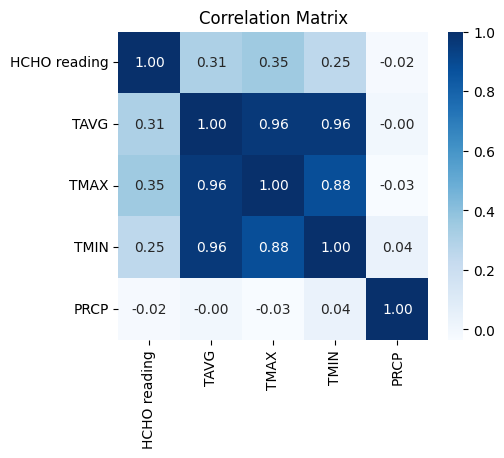

In [57]:
# plot the correlation matrix
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Task 3 - Machine Learning

### Adjust the dataframe

In [58]:
order = ['Current date', 'HCHO reading']

# reorder columns
colombo_hcho = hcho_df.filter(hcho_df['Location'] == 'Colombo Proper').select(*order)
colombo_hcho.show()
colombo_hcho.printSchema()

+------------+--------------------+
|Current date|        HCHO reading|
+------------+--------------------+
|  2019-01-01|1.969834395781014...|
|  2019-01-02|2.625522171968594...|
|  2019-01-03|9.852118897938794E-5|
|  2019-01-04|2.099320518114242E-4|
|  2019-01-05|1.785337298892930...|
|  2019-01-06|1.082296700235670...|
|  2019-01-08|9.153156350685351E-5|
|  2019-01-09|1.205978992853015...|
|  2019-01-10|1.297723562983258...|
|  2019-01-11|2.239188166801278...|
|  2019-01-12|1.569418094178759...|
|  2019-01-13|1.452855000520681...|
|  2019-01-14|1.336291906862603...|
|  2019-01-15|6.374417842690063E-5|
|  2019-01-16|1.181062250815020...|
|  2019-01-17|2.472555222423037...|
|  2019-01-18|3.667525352047757E-5|
|  2019-01-20|1.687856216479722...|
|  2019-01-23|2.147798144691999...|
|  2019-01-24|2.347245196410463E-4|
+------------+--------------------+
only showing top 20 rows

root
 |-- Current date: date (nullable = true)
 |-- HCHO reading: double (nullable = true)



In [59]:
# convert to pandas dataframe
colombo_pd = colombo_hcho.toPandas()
colombo_pd

,Current date,HCHO reading
0,2019-01-01,0.000197
1,2019-01-02,0.000263
2,2019-01-03,0.000099
3,2019-01-04,0.000210
4,2019-01-05,0.000179
...,...,...
1685,2023-12-27,0.000118
1686,2023-12-28,0.000125
1687,2023-12-29,0.000133
1688,2023-12-30,0.000140


### ARIMA model building

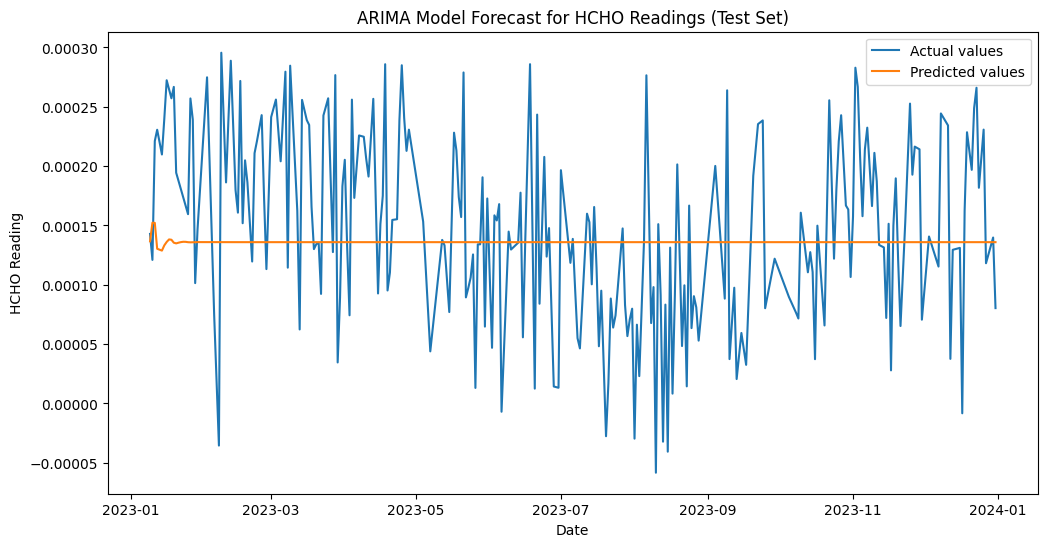

In [60]:
# Set 'Current date' column as index
colombo_pd.set_index('Current date', inplace=True)

# Convert index to datetime
colombo_pd.index = pd.to_datetime(colombo_pd.index)

# Split the data into train and test sets
train_size = int(len(colombo_pd) * 0.8)  
train, test = colombo_pd.iloc[:train_size], colombo_pd.iloc[train_size:]

# Train the ARIMA model using the training set
order = (5, 1, 0)
model = ARIMA(train, order=order)
fitted_model = model.fit()

# Get predictions for the test set
predictions = fitted_model.forecast(steps=len(test))

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual values')
plt.plot(test.index, predictions, label='Predicted values')
plt.title('ARIMA Model Forecast for HCHO Readings (Test Set)')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()


### Evaluate the model

In [61]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test, predictions)

# Calculate R-squared
r2 = r2_score(test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)

Mean Squared Error (MSE): 5.425462930555054e-09
Root Mean Squared Error (RMSE): 7.365774182361996e-05
Mean Absolute Error (MAE): 5.9620689329504016e-05
R-squared: -0.0136335024226093


In [62]:
# Define the range of parameters
p = d = q = range(0, 6)
pdq = list(itertools.product(p, d, q))

# Find the best parameters using grid search
best_mse = float('inf')
best_params = None

for param in pdq:
    try:
        model = ARIMA(train, order=param)
        fitted_model = model.fit()
        predictions = fitted_model.forecast(steps=len(test))
        mse = mean_squared_error(test, predictions)
        if mse < best_mse:
            best_mse = mse
            best_params = param
    except:
        continue

print("Best ARIMA parameters:", best_params)
print("Best Mean Squared Error:", best_mse)

Best ARIMA parameters: (1, 0, 5)
Best Mean Squared Error: 5.1837188589641365e-09


Best Mean Squared Error (MSE): 5.1837188589641365e-09
Best Root Mean Squared Error (RMSE): 7.199804760522424e-05
Best Mean Absolute Error (MAE): 5.837173953776562e-05
Best R-squared: 0.03153128685216233


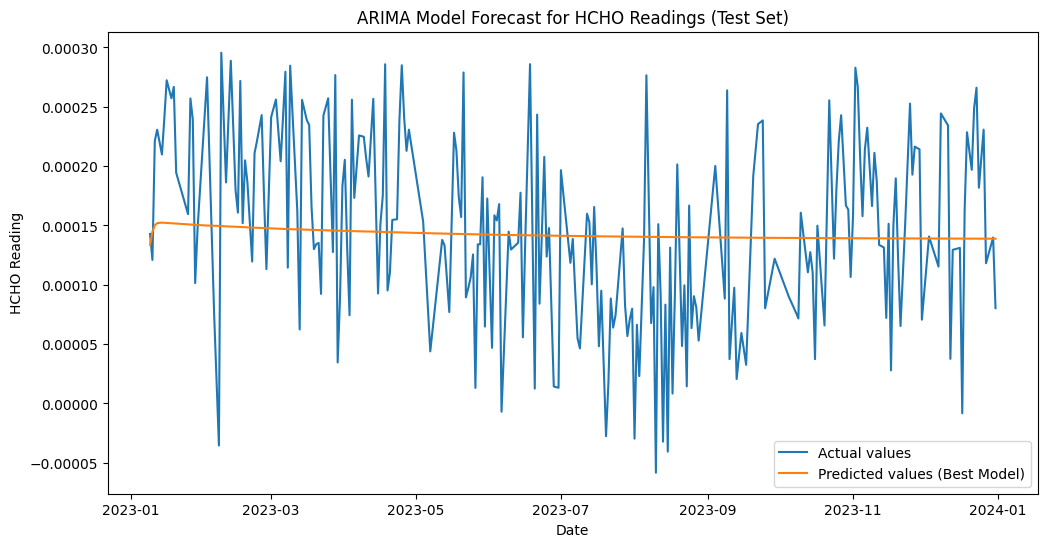

In [63]:
# Retrain the ARIMA model with the best parameters
best_model = ARIMA(train, order=best_params)
best_fitted_model = best_model.fit()

# Get predictions for the test set
best_predictions = best_fitted_model.forecast(steps=len(test))

# Calculate evaluation metrics
best_mse = mean_squared_error(test, best_predictions)
best_rmse = np.sqrt(best_mse)
best_mae = mean_absolute_error(test, best_predictions)
best_r2 = r2_score(test, best_predictions)

print("Best Mean Squared Error (MSE):", best_mse)
print("Best Root Mean Squared Error (RMSE):", best_rmse)
print("Best Mean Absolute Error (MAE):", best_mae)
print("Best R-squared:", best_r2)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual values')
plt.plot(test.index, best_predictions, label='Predicted values (Best Model)')
plt.title('ARIMA Model Forecast for HCHO Readings (Test Set)')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()